In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install transformers einops scikit-learn pandas matplotlib tqdm

from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt


In [3]:
tfbs_path = '/content/drive/MyDrive/genomics_project/data/ctcf_benchmark_dataset.csv'
df_tfbs = pd.read_csv(tfbs_path)
df_tfbs = df_tfbs.dropna()

print("TFBS dataset loaded. Shape:", df_tfbs.shape)
df_tfbs.head()

TFBS dataset loaded. Shape: (588494, 2)


,sequence,label
0,TAGATTTCATCTTTAATATTTTAAAATCAGAGTACTCTAGATTGTT...,0
1,CAGGGGAAATCTTGTTTTCTGAAGGGCAAATAAAACTCCCATCCTC...,0
2,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
3,ATATGTAGCTTGTCATAAAAATAAACAGTATTTATATACATTACAT...,0
4,AGTGAAACCTCGTCTCTACTAAAAATACAAAAATTAGCCGGGCATG...,0


In [4]:
model_name = "LongSafari/hyenadna-small-32k-seqlen-hf"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
model.eval()

print("HyenaDNA model loaded.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

tokenization_hyena.py:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- tokenization_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


special_tokens_map.json:   0%|          | 0.00/971 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

configuration_hyena.py:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- configuration_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hyena.py:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- modeling_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

HyenaDNA model loaded.


In [5]:
sequences = df_tfbs['sequence'].tolist()
labels = df_tfbs['label'].tolist()

print("Number of sequences:", len(sequences))


Number of sequences: 588494


In [6]:
accuracies = []
f1_scores = []
roc_aucs = []

for seed in [0, 1, 2, 3, 4]:
    print(f"\n=== TFBS Run {seed+1} ===")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Sample 25,000 sequences randomly (balance between speed and accuracy)
    df_sampled = df_tfbs.sample(n=25000, random_state=seed)
    sequences = df_sampled['sequence'].tolist()
    labels = df_sampled['label'].tolist()

    print(f"Sampled {len(sequences)} sequences.")

    # Get embeddings from HyenaDNA
    embeddings = []
    for seq in tqdm(sequences, desc=f"Embedding Run {seed+1}"):
        inputs = tokenizer(seq, return_tensors="pt", truncation=True, padding="max_length", max_length=1024)
        with torch.no_grad():
            outputs = model(**inputs)
        pooled = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(pooled)

    embeddings = np.array(embeddings)

    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=seed)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    accuracies.append(acc)
    f1_scores.append(f1)
    roc_aucs.append(auc)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")



=== TFBS Run 1 ===
Sampled 25000 sequences.


Embedding Run 1: 100%|██████████| 25000/25000 [13:50<00:00, 30.12it/s]


Accuracy: 0.5812
F1 Score: 0.6346
ROC AUC: 0.6288

=== TFBS Run 2 ===
Sampled 25000 sequences.


Embedding Run 2: 100%|██████████| 25000/25000 [13:23<00:00, 31.11it/s]


Accuracy: 0.5848
F1 Score: 0.6423
ROC AUC: 0.6254

=== TFBS Run 3 ===
Sampled 25000 sequences.


Embedding Run 3: 100%|██████████| 25000/25000 [13:54<00:00, 29.98it/s]


Accuracy: 0.5862
F1 Score: 0.6401
ROC AUC: 0.6242

=== TFBS Run 4 ===
Sampled 25000 sequences.


Embedding Run 4: 100%|██████████| 25000/25000 [13:31<00:00, 30.80it/s]


Accuracy: 0.5982
F1 Score: 0.6510
ROC AUC: 0.6338

=== TFBS Run 5 ===
Sampled 25000 sequences.


Embedding Run 5: 100%|██████████| 25000/25000 [13:52<00:00, 30.05it/s]


Accuracy: 0.5712
F1 Score: 0.6269
ROC AUC: 0.6123


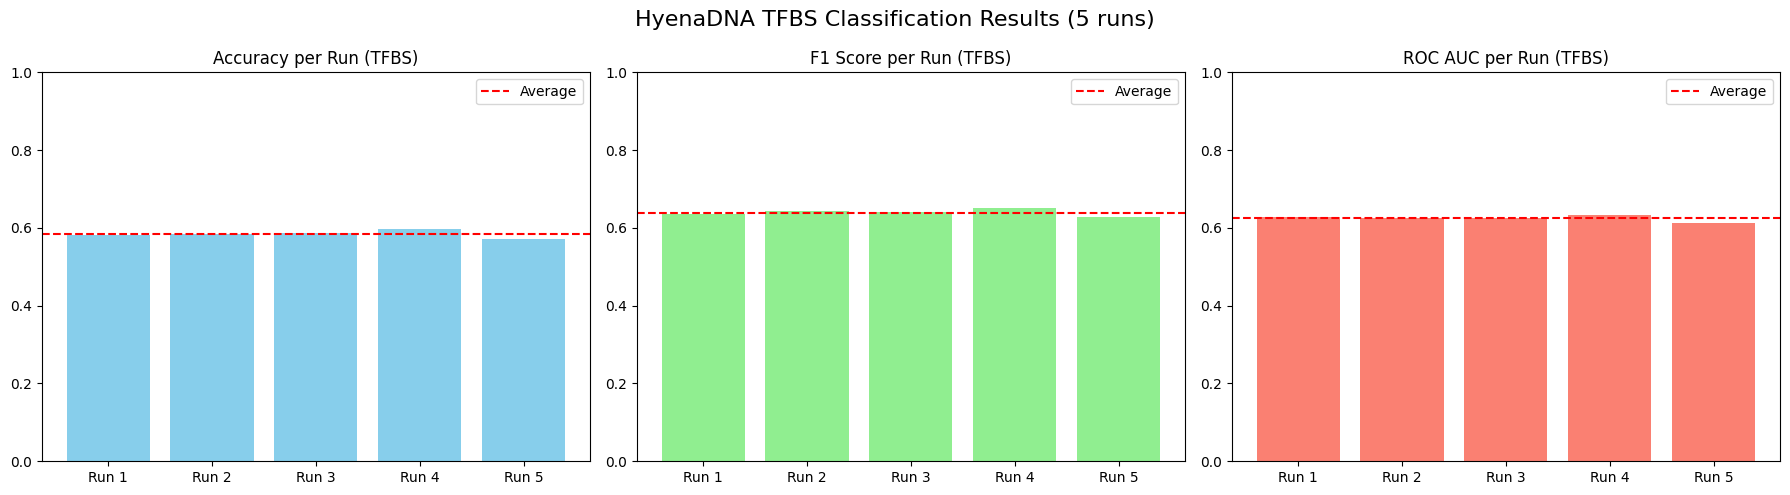

In [7]:
runs = [f"Run {i+1}" for i in range(5)]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(runs, accuracies, color='skyblue')
axs[0].axhline(y=np.mean(accuracies), color='red', linestyle='--', label='Average')
axs[0].set_title('Accuracy per Run (TFBS)')
axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].bar(runs, f1_scores, color='lightgreen')
axs[1].axhline(y=np.mean(f1_scores), color='red', linestyle='--', label='Average')
axs[1].set_title('F1 Score per Run (TFBS)')
axs[1].set_ylim(0, 1)
axs[1].legend()

axs[2].bar(runs, roc_aucs, color='salmon')
axs[2].axhline(y=np.mean(roc_aucs), color='red', linestyle='--', label='Average')
axs[2].set_title('ROC AUC per Run (TFBS)')
axs[2].set_ylim(0, 1)
axs[2].legend()

fig.suptitle('HyenaDNA TFBS Classification Results (5 runs)', fontsize=16)
plt.tight_layout()
plt.show()
